## Gaussian Process Emulation

Gaussian process emulation has been in use since 1980s as a well-known non-parametric Bayesian method. It builds *cheap-to-run* emulators for *expensive-to-run* simulation models (referred to as simulators) so as to enable analyses requiring a large number of simulation runs.

We will have a look at the [RobustGaSP](https://cran.r-project.org/web/packages/RobustGaSP/RobustGaSP.pdf) package maintained by [Mengyang Gu](mailto:mengyang@pstat.ucsb.edu) on how to perform predictions.

In [69]:
if (require("RobustGaSP") != T) {
    install.packages("RobustGaSP")
} else {
    library("RobustGaSP")
}

We wil use the borehole function, which models the water flow through a borehole, to generate output data, i.e. water flow rate in m<sup>3</sup>/year.

$$
f \left ( x \right ) = \frac{2\pi T_{u}\left ( H_{u} - H_{l} \right )}{\ln{\left (r/r_w  \right )}\left ( 1 + \frac{2LT_u}{\ln{\left (r/r_w  \right )r_{w}^{2}K_w}}+\frac{T_u}{T_l} \right )}
$$

We define the equation as a function named ```borehole_flowrate```

In [70]:
borehole_flowrate <- function(r_w, r, t_u, h_u, t_l, h_l, l, k_w) {
    nominator <- 2 * pi * t_u * (h_u - h_l)
    ln_term <- log(r / r_w)
    term1 <- (2 * l * t_u) / (ln_term * (r_w^2) * k_w)
    term2 <- t_u / t_l
    denominator <- ln_term * (1 + term1 + term2)
    result <- nominator / denominator
    return(result)
}

Input variables and ranges are taken from the [Virtual Library of Simulation Experiments](https://www.sfu.ca/~ssurjano/index.html).

| Parameter | Symbol | Unit | Range |
|----|----|----|----|
| Radius of borehole | r<sub>w</sub> | m | 0.05 - 0.15 |
| Radius of influence | r | m | 100 - 50000 |
| Transmissivity of upper aquifer | T<sub>u</sub> | m<sup>2</sup>/year | 63070 - 115600 |
| Potentiometric head of upper aquifer | H<sub>u</sub> | m | 990 - 1110 |
| Transmissivity of lower aquifer | T<sub>l</sub> | m<sup>2</sup>/year | 63.1 - 116 |
| Potentiometric head of lower aquifer | H<sub>l</sub> | m | 700 - 820 |
| Length of borehole | L | m | 1120 - 1680 |
| Hydraulic conductivity of borehole | K<sub>w</sub> | m<sup></sup>/year | 9855 - 12045 |

For the sake of simplicity, we assume that all parameters are uniformly distributed within their own ranges.

In [71]:
borehole_input <- function(number_of_runs) {
    radius_borehole <- runif(n = number_of_runs, min = 0.05, max = 0.15)
    radius_influence <- runif(n = number_of_runs, min = 100, max = 50000)
    trans_upper <- runif(n = number_of_runs, min = 63070, max = 115600)
    pot_upper <- runif(n = number_of_runs, min = 990, max = 1110)
    trans_lower <- runif(n = number_of_runs, min = 63.1, max = 116)
    pot_lower <- runif(n = number_of_runs, min = 700, max = 820)
    length_borehole <- runif(n = number_of_runs, min = 1120, max = 1680)
    cond_borehole <- runif(n = number_of_runs, min = 9855, max = 12045)
    data <- cbind(radius_borehole, radius_influence, trans_upper,
              pot_upper, trans_lower, pot_lower,
              length_borehole, cond_borehole)
    return(data)
}
input <- borehole_input(50)
head(input)

radius_borehole,radius_influence,trans_upper,pot_upper,trans_lower,pot_lower,length_borehole,cond_borehole
0.05730065,30692.09,86665.54,1030.243,93.04129,742.9214,1202.862,11522.26
0.05982286,30243.08,90700.64,1005.567,71.34334,704.6135,1460.921,11975.19
0.10904169,22774.27,105790.61,1084.775,63.11312,778.1944,1184.830,10683.12
0.12259225,38570.35,89636.09,1032.354,73.35173,779.5573,1314.999,10107.98
0.09892334,14140.92,88795.93,1004.661,88.97351,808.4966,1649.408,10164.48
0.09388682,23783.56,101881.61,1072.717,86.33371,773.8186,1169.384,10859.68


We now create the output vector with the randomly generated 50 parameter configurations.

In [72]:
output <- borehole_flowrate(r_w = input[, 1], r = input[, 2], t_u = input[, 3], h_u = input[, 4],
                  t_l = input[, 5], h_l = input[, 6],
                  l = input[, 7], k_w = input[, 8])
summary(output)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.67   40.35   67.36   72.34   95.09  188.60 

We can build a model with the input parametes as ```design``` and output as ```response```. We use the ```rgasp``` function for this.

In [80]:
model <- rgasp(design = input, response = output, lower_bound=FALSE)

The upper bounds of the range parameters are Inf Inf Inf Inf Inf Inf Inf Inf 
The initial values of range parameters are 0.0009800987 0.01999987 0.01999988 0.019951 0.01989054 0.01995001 0.01998869 0.01999729 
Start of the optimization  1  : 
The number of iterations is  28 
 The value of the  marginal posterior  function is  -355.7989 
 Optimized range parameters are 2.507378e+127 Inf Inf Inf Inf Inf Inf Inf 
 Optimized nugget parameter is 0 
 Convergence:  FALSE 
The initial values of range parameters are 0.574243 272413.1 285875.4 706.0604 315.5762 691.9524 3061.147 12788.42 
Start of the optimization  2  : 
The number of iterations is  50 
 The value of the  marginal posterior  function is  -140.7124 
 Optimized range parameters are 0.2476948 2.121347e+14 8.908589e+13 1076.889 34201620445 1120.5 2702.82 22788.22 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 


We can perform a prediction with the ```leave_one_out_rgasp``` function:

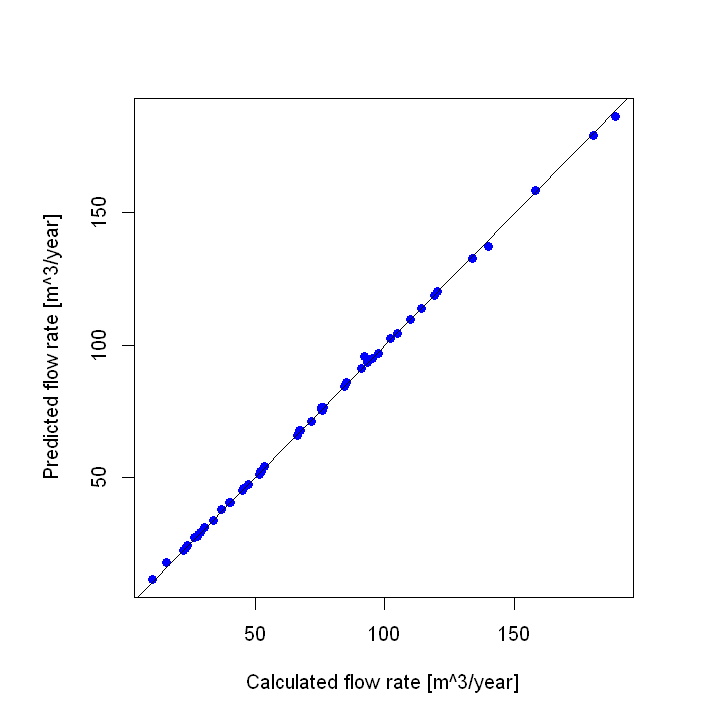

In [81]:
predicted <- leave_one_out_rgasp(model)
options(repr.plot.width=6, repr.plot.height=6)
par(pty = "s")
plot(predicted$mean~output, pch = 16, col = 4,
     xlab = "Calculated flow rate [m^3/year]", ylab = "Predicted flow rate [m^3/year]")
abline(0, 1)

You can watch an example of how to use Gaussian Process Emulation in emulating the output of landslide run-out simulations.

<div align="center">
  <a href="https://www.youtube.com/watch?v=BLdE9f5XOVM"><img src="https://img.youtube.com/vi/BLdE9f5XOVM/0.jpg" alt="IMAGE ALT TEXT"></a>
</div>